Smaller Notebook, which focuses only on the creation of cross correlation matrices, for later usage

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc
import scipy.linalg as la


import struct

Nt=16
w, h = 3, Nt
n_smear = 5
n_op = 4
n_meas = 100


def E_mass(L,mass):
    return np.arccosh(np.cosh(mass) + 1 -np.cos( 2*np.pi/L) )


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, np.transpose(a), rtol=rtol, atol=atol)

def corr_th(x, a,b,c,d):
    E= np.arccosh(2 - np.cos(2*np.pi/Nt))
    return a * np.cosh((x-Nt/2)*b) + c*np.cosh((x-Nt/2)*d)



def readfile(B_,Bphi_,B2_,BP2_,fn,kappa):
    b_l = w * 8
    ck = b_l*Nt*n_op
    Sm_ck = ck*n_smear
    with  open(fn,"rb" ) as f:
        fileContent =f.read()
        for n in range(n_meas):
            for ns in range(n_smear):
                for t in range(Nt):
                    B_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+b_l*t:(Sm_ck*n)+(ck*ns)+(t+1)*b_l])
                    B2_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt)+(t+1)*b_l])
                    Bphi_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+(t+1)*b_l])
                    BP2_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+(t+1)*b_l])
    print("File have been read")


    
    B1=[]
    for n in range(n_meas):
        B1.append(B_[n][0][0])
    plt.plot(B1, label='B[0][0] kappa=%d '%kappa)
    plt.legend()
    plt.show
    
    
def cross_correlator(c_var,kappa):
    O = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O1 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O2 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O3 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O_sq = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
    
    
    for n in range(n_meas):
        for ns in range(n_smear):
            for t in range(Nt):
                for k in range(2):
                    O[n][ns][t] += B[n][ns][t][k]/2
                    O1[n][ns][t] += B1[n][ns][t][k]/2
                    O3[n][ns][t] += B3[n][ns][t][k]/2
                O_sq[n][ns][t] = O[n][ns][t]*O[n][ns][t] 
                for k in range(2):
                    O2[n][ns][t] += (O_sq[n][ns][t]*B[n][ns][t][k])/2
                    
    
    c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    for n in range(n_meas):
        for i in range(n_smear):
            for j in range(n_smear):
                for t in range(Nt):
                    for t_pr in range(Nt):
                            c_var[n][i][j][t]                     += (O [n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+n_smear][t]     += (O1[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+2*n_smear][t] += (O2[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+3*n_smear][t] += (O3[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i][j+n_smear][t]             += (O [n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i][j+2*n_smear][t]           += (O [n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i][j+3*n_smear][t]           += (O [n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j][t]             += (O1[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j][t]           += (O2[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j][t]           += (O3[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+2*n_smear][t]   += (O1[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+3*n_smear][t]   += (O1[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+3*n_smear][t] += (O2[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+n_smear][t]   += (O2[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+n_smear][t]   += (O3[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+2*n_smear][t] += (O3[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
    print("cross correlators filled")
    '''
    plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
    for ns in range(n_smear):
        C=[]
        for n in range(n_meas):
            C.append(c_var[n][0][ns][ns])
        plt.scatter(x = list(range(n_meas)),y=C,label='C[0][%d][%d] kappa=%f '%(ns,ns,kappa))
        plt.legend()
        plt.show
    '''
    
def cross_corr_stat(c_res,c,kappa):
    #f = open('matrix.txt', 'w')
    #f1 = open('matrix_err.txt', 'w')
    c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_mat_err = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_res[0] = [[[0 for t in range(Nt)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op)  ]
    #c_res[0] = np.mean(c,axis =0 )
    for t in range(Nt):
        for i in range(n_smear*n_op):
            for j in range(n_smear*n_op):
                #c_res[0][i][j][t] =0 
                for n in range(n_meas):
                    c_res[0][i][j][t] += (c[n][i][j][t]+c[n][j][i][t] )/(2*n_meas) 
    
    #c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    #for t in range(Nt):
    #    for i in range(n_smear*n_op):
    #        for j in range(n_smear*n_op):
    #            c_mat[i][j] = c_res[0][i][j][t]
    #    print('t= '+str(t)+str(check_symmetric(c_mat)))
    #print(c_res[0][0][0])
    c_res[1] = np.std(c,axis =0 )
    c_res[2] = [[[0 for t in range(Nt)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op)  ]
    for i in range(n_smear*n_op):
        for j in range(n_smear*n_op):
            for t in range(Nt):
                vec = []
                for n in range(n_meas):
                    vec.append(float(c[n][i][j][t]))
                c_res[2][i][j][t] = phmc.integrated_autocorr6(np.array(vec),6)
                #c_res[2][ns][t] =1
                print(c_res[2][i][j][t])
                c_res[1][i][j][t] = c_res[1][i][j][t]* np.sqrt(c_res[2][i][j][t]/n_meas)
    with open('cross/matrix_np_L%d_k%f.txt' %(Nt,kappa),'w')  as outfile:
        with open('cross/matrix_np_L%d_k%f_err.txt'%(Nt,kappa),'w') as errfile:
            for t in range(Nt):
                for i in range(n_smear*n_op):
                    for j in range(n_smear*n_op):
                        c_mat[i][j]=float(c_res[0][i][j][t])
                        c_mat_err[i][j]=float(c_res[1][i][j][t])
                        
                c_mat =np.array(c_mat)
                c_mat_err =np.array(c_mat_err)
        
                #np.savetxt(outfile ,c_mat,fmt='%.6f')
                #outfile.write('# New time slice\n')
                #np.savetxt(errfile ,c_mat_err,fmt='%.6f')
                #errfile.write('# New time slice\n')
               
    
    print("Averages and uncertainties obtained")
  
B = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
B1 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
B2 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
B3 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]

C_var= [[[[0 for y in range(h)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ] for n in range(n_meas) ]
C_var_res = [[[0 for j in range(n_smear) ]for i in range(n_smear) ] for y in range (3) ]


def var_analysis_stat(kappa):
    filename = "O1minus_output_files_2/output_Nt%d_Nx%d_Ny%d_Nz%d_B4.000000_K%f_L1.000000.bin" % (Nt,Nt,Nt,Nt,kappa)
    #filename = "O1minus_output_files_new/output_Nt32_Nx32_Ny32_Nz32_B4.000000_K0.550000_L1.000000_full.bin"
    readfile(B,B1,B2,B3,filename,kappa)                 
    cross_correlator(C_var,kappa)      
    cross_corr_stat(C_var_res,C_var,kappa)
    
    

File have been read
cross correlators filled
[2.8754745]
[2.11667879]
[2.57915326]
[2.47489565]
[2.36204086]
[2.65091646]
[2.37970301]
[2.76280056]
[3.15997874]
[2.76280056]
[2.37970301]
[2.65091646]
[2.36204086]
[2.47489565]
[2.57915326]
[2.11667879]
[2.22720393]
[2.36827879]
[2.57025526]
[2.86934418]
[2.64013537]
[2.64387266]
[2.12608078]
[2.33498133]
[3.00014086]
[2.33498133]
[2.12608078]
[2.64387266]
[2.64013537]
[2.86934418]
[2.57025526]
[2.36827879]
[1.44977428]
[1.39411473]
[2.3145341]
[2.18849733]
[2.81623486]
[1.97381247]
[1.97101473]
[2.13674023]
[2.47912066]
[2.13674023]
[1.97101473]
[1.97381247]
[2.81623486]
[2.18849733]
[2.3145341]
[1.39411473]
[1.4636002]
[1.86809186]
[1.95749172]
[1.91934681]
[2.49939886]
[2.82195043]
[2.97613276]
[2.82714025]
[2.35488054]
[2.82714025]
[2.97613276]
[2.82195043]
[2.49939886]
[1.91934681]
[1.95749172]
[1.86809186]
[2.22124837]
[2.18783483]
[1.97232969]
[2.0153603]
[2.49008596]
[2.74247284]
[3.14321736]
[2.65969375]
[2.57671526]
[2.65969375

[2.72641826]
[2.59141689]
[2.31934759]
[2.11039973]
[1.34985887]
[1.61134221]
[2.19836033]
[2.58614232]
[2.71110757]
[2.64375807]
[2.68547034]
[2.55734752]
[3.37165454]
[2.55734752]
[2.68547034]
[2.64375807]
[2.71110757]
[2.58614232]
[2.19836033]
[1.61134221]
[1.61953653]
[2.92114483]
[2.4868093]
[2.98675012]
[2.48915803]
[2.79837826]
[2.19803536]
[1.60021386]
[3.48402532]
[1.60021386]
[2.19803536]
[2.79837826]
[2.48915803]
[2.98675012]
[2.4868093]
[2.92114483]
[3.03262892]
[3.05955761]
[2.33708146]
[2.04149893]
[2.4676501]
[2.80917828]
[2.37001111]
[2.14755292]
[3.63794418]
[2.14755292]
[2.37001111]
[2.80917828]
[2.4676501]
[2.04149893]
[2.33708146]
[3.05955761]
[2.92390152]
[2.06934806]
[1.95447045]
[2.85139257]
[2.85689448]
[2.99591448]
[2.98776483]
[2.0767736]
[2.38106417]
[2.0767736]
[2.98776483]
[2.99591448]
[2.85689448]
[2.85139257]
[1.95447045]
[2.06934806]
[2.62425713]
[2.59883412]
[2.65224455]
[3.07575712]
[2.9927968]
[3.06135175]
[2.68722537]
[2.15557541]
[2.59672281]
[2.155

[1.98789883]
[2.33750644]
[2.81663855]
[2.33750644]
[1.98789883]
[2.68076404]
[2.9790176]
[2.75571451]
[2.44964197]
[2.15591578]
[1.87837842]
[2.26686588]
[2.66334615]
[2.57181433]
[2.73915493]
[2.62578505]
[2.18868827]
[2.49519359]
[2.31867707]
[2.49519359]
[2.18868827]
[2.62578505]
[2.73915493]
[2.57181433]
[2.66334615]
[2.26686588]
[2.47616162]
[2.94872238]
[2.51162607]
[2.3099164]
[2.60158216]
[2.31571181]
[2.42920252]
[2.92665826]
[2.3596922]
[2.92665826]
[2.42920252]
[2.31571181]
[2.60158216]
[2.3099164]
[2.51162607]
[2.94872238]
[2.24428444]
[2.79160794]
[3.07723996]
[2.26798351]
[3.332125]
[2.51998961]
[2.59716805]
[2.27369919]
[2.5983342]
[2.27369919]
[2.59716805]
[2.51998961]
[3.332125]
[2.26798351]
[3.07723996]
[2.79160794]
[2.49471862]
[2.54146031]
[2.62818941]
[2.585682]
[2.80903264]
[1.94361526]
[2.50734684]
[2.62606091]
[3.04955348]
[2.62606091]
[2.50734684]
[1.94361526]
[2.80903264]
[2.585682]
[2.62818941]
[2.54146031]
[2.46085394]
[2.20055005]
[2.46054455]
[2.38566373]

[1.81218503]
[2.39674996]
[2.20313265]
[2.65166153]
[3.31588046]
[2.65166153]
[2.20313265]
[2.39674996]
[1.81218503]
[1.88065169]
[1.78398533]
[2.99302576]
[2.64815013]
[3.31646277]
[1.73736511]
[2.11395737]
[1.78037494]
[2.4414982]
[2.67744472]
[2.5835475]
[2.59479499]
[2.5835475]
[2.67744472]
[2.4414982]
[1.78037494]
[2.11395737]
[1.73736511]
[3.31646277]
[3.4696277]
[3.53792441]
[2.16012517]
[2.5706167]
[2.15734551]
[1.84659374]
[2.37811972]
[3.20343515]
[3.55187766]
[3.20343515]
[2.37811972]
[1.84659374]
[2.15734551]
[2.5706167]
[2.16012517]
[3.53792441]
[2.41148098]
[2.38989387]
[2.48439437]
[2.12276457]
[2.63499715]
[2.44503689]
[2.84157599]
[2.51978662]
[4.2637001]
[2.51978662]
[2.84157599]
[2.44503689]
[2.63499715]
[2.12276457]
[2.48439437]
[2.38989387]
[2.92701012]
[2.32280344]
[2.79091987]
[2.44524617]
[2.16145761]
[2.44867824]
[2.42499036]
[2.39026095]
[2.06292127]
[2.39026095]
[2.42499036]
[2.44867824]
[2.16145761]
[2.44524617]
[2.79091987]
[2.32280344]
[2.9038505]
[2.76748

[2.64837615]
[2.48574303]
[3.01867307]
[2.68685406]
[2.69679102]
[2.70805654]
[2.4136485]
[2.78004595]
[2.68855748]
[2.31985279]
[2.66924012]
[2.00478231]
[1.89356614]
[2.72315814]
[1.89356614]
[2.00478231]
[2.66924012]
[2.31985279]
[2.68855748]
[2.78004595]
[2.4136485]
[1.65874222]
[2.01415637]
[2.13544372]
[1.89383115]
[2.63032481]
[2.79502732]
[3.04532321]
[2.85672555]
[2.58985907]
[2.85672555]
[3.04532321]
[2.79502732]
[2.63032481]
[1.89383115]
[2.13544372]
[2.01415637]
[2.46085394]
[2.20055005]
[2.46054455]
[2.38566373]
[2.92071998]
[2.12921766]
[2.64384791]
[1.90837846]
[3.33263643]
[1.90837846]
[2.64384791]
[2.12921766]
[2.92071998]
[2.38566373]
[2.46054455]
[2.20055005]
[2.10002926]
[2.16029356]
[2.6238317]
[2.31511774]
[2.55281344]
[2.62088779]
[2.52431611]
[2.13211816]
[3.26492327]
[2.13211816]
[2.52431611]
[2.62088779]
[2.55281344]
[2.31511774]
[2.6238317]
[2.16029356]
[2.36734224]
[3.35338821]
[2.58430163]
[2.96731968]
[2.49190451]
[2.87273348]
[1.97787286]
[1.45741139]
[4.

[2.16240868]
[1.72544931]
[2.15039863]
[1.95651841]
[1.55270427]
[1.87739646]
[1.69406251]
[4.23100544]
[3.77335049]
[3.3658183]
[2.86023085]
[3.3658183]
[3.77335049]
[4.23100544]
[1.69406251]
[1.87739646]
[1.55270427]
[1.95651841]
[2.31250156]
[3.31523538]
[3.14131596]
[2.25197507]
[3.42518432]
[2.41816419]
[2.26844421]
[3.20321374]
[2.77727409]
[3.20321374]
[2.26844421]
[2.41816419]
[3.42518432]
[2.25197507]
[3.14131596]
[3.31523538]
[1.81282699]
[3.2861953]
[2.55767281]
[2.12011727]
[1.95759602]
[3.0214797]
[3.30579465]
[2.66537381]
[2.2979109]
[2.66537381]
[3.30579465]
[3.0214797]
[1.95759602]
[2.12011727]
[2.55767281]
[3.2861953]
[2.07636526]
[2.17474695]
[2.65644332]
[1.89732669]
[2.66589005]
[3.10480365]
[2.72541925]
[2.7601006]
[2.38783008]
[2.7601006]
[2.72541925]
[3.10480365]
[2.66589005]
[1.89732669]
[2.65644332]
[2.17474695]
[1.8955218]
[1.69339423]
[2.2915823]
[2.68921852]
[2.14166783]
[3.9951353]
[4.15881355]
[3.44392818]
[2.13358057]
[3.44392818]
[4.15881355]
[3.9951353]

[2.79733288]
[3.23252431]
[2.67990088]
[2.19870713]
[2.34067259]
[2.4318033]
[2.77846305]
[2.73292698]
[2.77846305]
[2.4318033]
[2.34067259]
[2.19870713]
[2.67990088]
[3.23252431]
[2.79733288]
[2.48898815]
[2.52970506]
[2.65635004]
[3.05205001]
[2.8708484]
[2.72264132]
[2.45756684]
[2.4745448]
[2.38618219]
[2.4745448]
[2.45756684]
[2.72264132]
[2.8708484]
[3.05205001]
[2.65635004]
[2.52970506]
[2.98572788]
[3.07900678]
[2.79973841]
[1.84053354]
[2.07163198]
[2.13745242]
[2.09804727]
[3.82145643]
[2.57689323]
[3.82145643]
[2.09804727]
[2.13745242]
[2.07163198]
[1.84053354]
[2.79973841]
[3.07900678]
[3.41288242]
[2.84623148]
[2.28991617]
[2.62816331]
[2.47439799]
[3.63796021]
[3.67066806]
[3.27017762]
[2.40192836]
[3.27017762]
[3.67066806]
[3.63796021]
[2.47439799]
[2.62816331]
[2.28991617]
[2.84623148]
[2.75202916]
[2.57857582]
[2.40204367]
[2.07649355]
[2.71516601]
[2.88660141]
[3.17810668]
[2.49479681]
[2.20824636]
[2.49479681]
[3.17810668]
[2.88660141]
[2.71516601]
[2.07649355]
[2.40

[3.28526516]
[3.1358682]
[3.13015559]
[2.70060294]
[2.44065492]
[2.37046734]
[2.27756794]
[2.24087801]
[1.98059973]
[2.58627023]
[2.49836503]
[2.19466374]
[2.20382961]
[2.66420459]
[2.74288101]
[2.66420459]
[2.20382961]
[2.19466374]
[2.49836503]
[2.58627023]
[1.98059973]
[2.24087801]
[2.07498815]
[2.05977947]
[2.29449754]
[2.40055372]
[2.43335896]
[2.19697422]
[2.55692576]
[2.48038607]
[2.44249131]
[2.48038607]
[2.55692576]
[2.19697422]
[2.43335896]
[2.40055372]
[2.29449754]
[2.05977947]
[1.56968142]
[2.07352049]
[2.03274332]
[2.11579368]
[2.24393752]
[2.33655652]
[2.15073882]
[2.8331297]
[2.3275587]
[2.8331297]
[2.15073882]
[2.33655652]
[2.24393752]
[2.11579368]
[2.03274332]
[2.07352049]
[1.53084219]
[3.41684207]
[2.35313156]
[2.17667222]
[3.78752168]
[2.3655285]
[2.98257359]
[2.38266971]
[2.57250385]
[2.38266971]
[2.98257359]
[2.3655285]
[3.78752168]
[2.17667222]
[2.35313156]
[3.41684207]
[2.97243748]
[2.9795822]
[2.77974767]
[2.51830595]
[3.02974919]
[2.74601671]
[3.37548789]
[3.924

[2.69854604]
[2.16010091]
[2.24938163]
[2.27836149]
[1.52072436]
[2.47111438]
[2.35040022]
[2.35484715]
[2.90463808]
[2.67422516]
[3.7769984]
[3.63970395]
[2.91837358]
[2.78918555]
[2.91837358]
[3.63970395]
[3.7769984]
[2.67422516]
[2.90463808]
[2.35484715]
[2.35040022]
[2.39921756]
[2.89453728]
[2.32946739]
[2.16891013]
[2.27796437]
[3.01241281]
[3.58851485]
[2.80846636]
[2.65628446]
[2.80846636]
[3.58851485]
[3.01241281]
[2.27796437]
[2.16891013]
[2.32946739]
[2.89453728]
[2.73742244]
[2.66889731]
[2.3878978]
[2.00527787]
[2.09543242]
[2.6300904]
[2.44662462]
[2.50625429]
[2.69382954]
[2.50625429]
[2.44662462]
[2.6300904]
[2.09543242]
[2.00527787]
[2.3878978]
[2.66889731]
[2.54461908]
[2.55681375]
[2.94184794]
[2.33903352]
[2.34019296]
[2.34889712]
[2.37515155]
[2.27187093]
[2.2699603]
[2.27187093]
[2.37515155]
[2.34889712]
[2.34019296]
[2.33903352]
[2.94184794]
[2.55681375]
[2.05789772]
[2.0399559]
[2.04051752]
[1.92680896]
[2.3253]
[2.26523559]
[3.08698623]
[2.63621251]
[2.62389292

[1.90904122]
[1.42715808]
[1.64532488]
[2.09842577]
[1.90395329]
[2.07985673]
[2.10785218]
[2.26045359]
[1.98346531]
[2.34523199]
[1.9708233]
[2.34523199]
[1.98346531]
[2.26045359]
[2.10785218]
[2.07985673]
[1.90395329]
[2.09842577]
[1.28564]
[2.58595036]
[2.0786296]
[1.93607273]
[3.62660411]
[2.36093655]
[2.39702781]
[2.32331182]
[2.25126011]
[2.32331182]
[2.39702781]
[2.36093655]
[3.62660411]
[1.93607273]
[2.0786296]
[2.58595036]
[2.2773971]
[3.15299632]
[2.34615193]
[2.39612186]
[3.09045823]
[3.15143904]
[3.39161626]
[3.47236078]
[3.03188306]
[3.47236078]
[3.39161626]
[3.15143904]
[3.09045823]
[2.39612186]
[2.34615193]
[3.15299632]
[2.19118855]
[2.37349976]
[2.12466231]
[2.45416403]
[2.30281194]
[2.32736039]
[2.06080336]
[2.01677206]
[2.06148646]
[2.01677206]
[2.06080336]
[2.32736039]
[2.30281194]
[2.45416403]
[2.12466231]
[2.37349976]
[1.91297205]
[1.93503994]
[2.1381858]
[2.12453478]
[2.77555444]
[2.62198329]
[2.41702037]
[2.03612653]
[1.89448029]
[2.03612653]
[2.41702037]
[2.6219

[2.09913716]
[1.94082089]
[2.03883052]
[1.94082089]
[2.09913716]
[2.97734692]
[3.32185416]
[1.97620346]
[2.15991372]
[2.25912468]
[2.59776621]
[3.15581604]
[2.24106814]
[2.14903095]
[3.30529676]
[3.20473695]
[2.02651213]
[1.86020237]
[2.11342467]
[1.86020237]
[2.02651213]
[3.20473695]
[3.30529676]
[2.14903095]
[2.24106814]
[3.15581604]
[1.63212464]
[2.62796579]
[2.12876459]
[2.21017603]
[2.68207519]
[3.72226332]
[3.21472643]
[2.9801602]
[2.93529394]
[2.9801602]
[3.21472643]
[3.72226332]
[2.68207519]
[2.21017603]
[2.12876459]
[2.62796579]
[1.48943577]
[2.02019565]
[2.15565952]
[1.92962632]
[2.28391476]
[1.88904667]
[2.10035531]
[1.88084828]
[2.06137972]
[1.88084828]
[2.10035531]
[1.88904667]
[2.28391476]
[1.92962632]
[2.15565952]
[2.02019565]
[1.91297205]
[1.93503994]
[2.1381858]
[2.12453478]
[2.77555444]
[2.62198329]
[2.41702037]
[2.03612653]
[1.89448029]
[2.03612653]
[2.41702037]
[2.62198329]
[2.77555444]
[2.12453478]
[2.1381858]
[1.93503994]
[1.49348773]
[2.32176309]
[2.28199639]
[2.

[2.15668233]
[2.17134908]
[2.34771666]
[2.65294699]
[3.42400523]
[2.71979445]
[2.47201438]
[2.00033655]
[1.84533762]
[2.00033655]
[2.47201438]
[2.71979445]
[3.42400523]
[2.65294699]
[2.34771666]
[2.17134908]
[2.44376827]
[3.00235701]
[2.15471385]
[1.80188292]
[2.31740437]
[2.37673021]
[2.60092349]
[3.98729513]
[3.77605921]
[3.98729513]
[2.60092349]
[2.37673021]
[2.31740437]
[1.80188292]
[2.15471385]
[3.00235701]
[3.15528272]
[2.56050397]
[2.39043597]
[2.6113517]
[2.46756583]
[2.57584781]
[2.75692241]
[4.41280627]
[4.30812507]
[4.41280627]
[2.75692241]
[2.57584781]
[2.46756583]
[2.6113517]
[2.39043597]
[2.56050397]
[2.277009]
[3.66834641]
[3.6257017]
[2.32422346]
[3.09360878]
[2.48758166]
[4.51639804]
[2.68999043]
[4.09662203]
[2.68999043]
[4.51639804]
[2.48758166]
[3.09360878]
[2.32422346]
[3.6257017]
[3.66834641]
[4.23375384]
[3.35409747]
[2.7979539]
[3.04099353]
[3.4472157]
[3.33115799]
[2.21897086]
[2.26412923]
[2.12026476]
[2.26412923]
[2.21897086]
[3.33115799]
[3.4472157]
[3.04099

[1.80657737]
[3.10131993]
[2.55010725]
[2.30657062]
[2.45927629]
[2.24460865]
[2.45927629]
[2.30657062]
[2.55010725]
[3.10131993]
[1.80657737]
[2.31807523]
[3.31521606]
[2.47800927]
[2.75717623]
[2.65968947]
[2.3946448]
[2.29501379]
[3.28988601]
[2.67643506]
[2.69413401]
[2.76046506]
[2.69413401]
[2.67643506]
[3.28988601]
[2.29501379]
[2.3946448]
[2.65968947]
[2.75717623]
[2.40756375]
[2.11276563]
[3.32472145]
[2.28171354]
[2.35112185]
[3.01573642]
[2.47909023]
[2.30064641]
[2.60865563]
[2.30064641]
[2.47909023]
[3.01573642]
[2.35112185]
[2.28171354]
[3.32472145]
[2.11276563]
[2.13876523]
[2.08701117]
[1.97577755]
[2.79836085]
[2.42809688]
[2.91430426]
[2.23195521]
[2.05220655]
[2.16665525]
[2.05220655]
[2.23195521]
[2.91430426]
[2.42809688]
[2.79836085]
[1.97577755]
[2.08701117]
[2.7905905]
[2.33521916]
[2.91387717]
[2.39841129]
[1.98930473]
[2.40958842]
[2.2574182]
[2.16441007]
[2.17819641]
[2.16441007]
[2.2574182]
[2.40958842]
[1.98930473]
[2.39841129]
[2.91387717]
[2.33521916]
[2.1

[2.20023249]
[1.96873459]
[2.28467614]
[2.58713129]
[2.27585314]
[1.78164149]
[2.88863262]
[2.74760222]
[2.81083454]
[2.94183635]
[2.71050006]
[2.94183635]
[2.81083454]
[2.74760222]
[2.88863262]
[1.78164149]
[2.27585314]
[2.58713129]
[3.07830384]
[3.12632422]
[2.4263144]
[2.05831714]
[2.2481448]
[2.5550933]
[2.64595753]
[2.29949288]
[3.16511894]
[2.29949288]
[2.64595753]
[2.5550933]
[2.2481448]
[2.05831714]
[2.4263144]
[3.12632422]
[2.57472148]
[2.82476703]
[2.51895374]
[2.31059351]
[2.32542575]
[2.07719357]
[1.63585663]
[1.70459062]
[3.18451724]
[1.70459062]
[1.63585663]
[2.07719357]
[2.32542575]
[2.31059351]
[2.51895374]
[2.82476703]
[2.73733609]
[3.04690101]
[2.2012208]
[2.34636521]
[2.23187843]
[1.87178517]
[2.08716325]
[3.80560733]
[2.68940741]
[3.80560733]
[2.08716325]
[1.87178517]
[2.23187843]
[2.34636521]
[2.2012208]
[3.04690101]
[2.0642207]
[2.10054832]
[2.29184352]
[2.2124829]
[2.39921769]
[2.35099558]
[2.2594097]
[2.28018045]
[2.4244521]
[2.28018045]
[2.2594097]
[2.35099558]

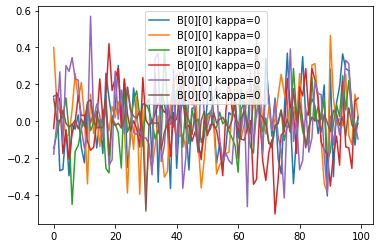

In [10]:
for k in range(2):
    kappa = 0.55+ k*0.1
    var_analysis_stat(kappa)